In [4]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage import filters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## With Real Data

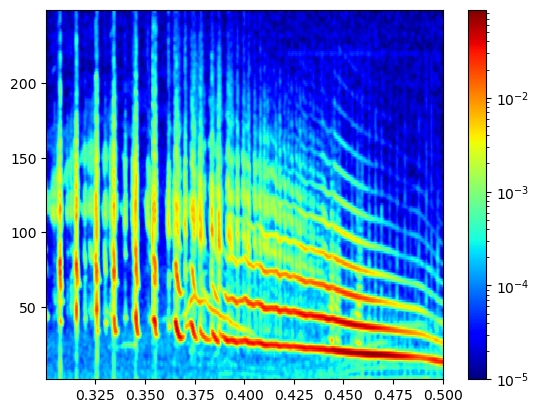

In [11]:
dataset = xr.open_zarr('data/spectrograms/29115.zarr')
dataset = dataset.sel(time=(dataset.time > 0.3) & (dataset.time < .5))
spectrogram = dataset.omaha_3lz
spectrogram['frequency'] = spectrogram.frequency / 1000
spectrogram = spectrogram.sel(frequency=(spectrogram.frequency > 1) & (spectrogram.frequency < 250))
spectrogram.values = np.abs(spectrogram.values)

# Filter spectrogram a little to reduce noise
spectrogram.values = filters.gaussian(spectrogram.values)

x = spectrogram.frequency.values

plt.figure()
cax = plt.pcolormesh(
        spectrogram.time,
        spectrogram.frequency,
        np.abs(spectrogram),
        shading="nearest",
        cmap="jet",
        norm=LogNorm(vmin=1e-5),
    )
plt.colorbar()

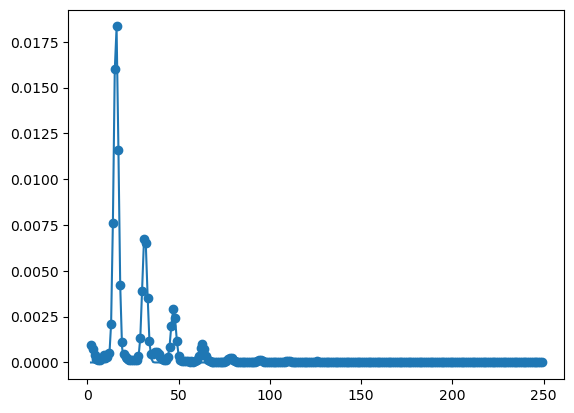

In [12]:
from scipy.optimize import curve_fit

class GaussianModel:
    
    def __init__(self, heights, centers, widths):
        self.n_components = len(heights)
        p0 = []
        for i in range(self.n_components):
            p0.extend([heights[i], centers[i], widths[i]])
        
        self.p0 = p0

    def __call__(self, x, *args):
        params = args
        components = []
        for i in range(self.n_components):
            a, mu, sigma = params[i*3:i*3+3]
            comp = a * np.exp(-(x - mu)**2 / (2 * sigma**2))
            components.append(comp)

        return sum(components)

    def fit(self, x_data, y_data):
        popt, pconv = curve_fit(self, x_data, y_data, p0=self.p0)
        return self(x_data, *popt), popt
            

y_data = spectrogram.values[:, -20]
x_data = spectrogram.frequency.values

def fit_peaks(x_data, y_data):
    index, props = signal.find_peaks(y_data, height=.001, width=3)
    centers = x_data[index]
    heights = props['peak_heights']
    widths = props['widths']

    model = GaussianModel(heights, centers, widths)
    y_fit, popt = model.fit(x_data, y_data)
    return y_fit, popt

y_fit, popt = fit_peaks(x_data, y_data)
plt.scatter(x_data, y_data)
plt.plot(x_data, y_fit)

peaks = popt[1:-2:3]

/var/folders/xr/yr8z575s52b4tbg3fj65qwx00000gp/T/ipykernel_51306/3158945227.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pconv = curve_fit(self, x_data, y_data, p0=self.p0)


(2.0, 249.0)

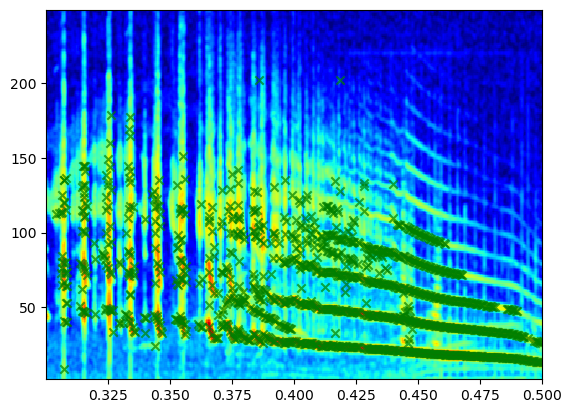

In [13]:
all_peaks_y = []
all_peaks_x = []
for i in range(spectrogram.shape[1]):
    y = spectrogram.values[:, i]
    x = spectrogram.frequency.values

    try:
        y_fit, popt = fit_peaks(x, y)
        peaks = popt[1:-2:3]
        x_peaks = [x] * len(peaks)
        all_peaks_y.extend(peaks)
        all_peaks_x.extend([spectrogram.time.values[i]] * len(peaks))
    except:
        pass

    
cax = plt.pcolormesh(
        spectrogram.time,
        spectrogram.frequency,
        np.abs(spectrogram),
        shading="nearest",
        cmap="jet",
        norm=LogNorm(vmin=1e-5),
    )

plt.scatter(all_peaks_x, all_peaks_y, marker='x', alpha=0.7, c='green')
plt.ylim(spectrogram.frequency.min(), spectrogram.frequency.max())